# Rain Analysis
### Purpose
This notebook will look at volunteer trends for reporting rain, adressing the Github issue #54

### Author: 
Hamza El-Saawy
### Date: 
2020-06-14
### Update Date: 
2020-06-14

### Inputs 
 - `1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt`

### Output Files
`2.1-cbc_prcp_1900-2018.csv`: A reduced CBC dataset consisiting of only rain (precipitaion) data and an analysis of that data compared to the NOAA GHCN data

## Steps or Proceedures in the notebook 
 - Clean the CBC data
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
The project Google Drive, at: https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

## Notes
the flattened NOAA BigQuery drops the `QFLAG` column, so we cannot drop erroneous data and also does not contain the `WT**` `element` values (which can be used alongside the `PRCP` fields to determin precipitation)

Additionally, 1.1 drops rows where `temp_min_value`, `temp_max_value`, `temp_avg`, and `snow` are `nan`, but they could have usable values for `[am|pm]_[rain|snow]`, since it is much easier to annotate if weather happened vs taking measurments.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

The cleaned data set, `1.0-rec-initial-data-cleaning.txt`, drops circles with "impossible" temperture, wind, and snow values, which we still find valuable here since we assume that even mistaken/erroneous temp/wind data can still have valuable precipitation data

In [25]:
#
#
#

# drop all stations farther than this threshold (meters)
#  the farthers is ~36km, with the average being 10km
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# consider stations to consense on a rain/snow value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around that: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREMENT_THRESHOLD = 0.75
#
#
#

In [4]:
DATA_PATH = '../data/Cloud_Data'
RAW_DATA_PATH = os.path.join(DATA_PATH, 'cbc_effort_weather_1900-2018.txt')
CLN_DATA_PATH = os.path.join(DATA_PATH, '1.0-rec-initial-data-cleaning.txt')
NOAA_DATA_PATH = os.path.join(DATA_PATH, '1.1-circles_to_many_stations_usa_weather_data_20200623005013.txt')
CBC_PRCP_PATH = os.path.join(DATA_PATH, 'cbc_prcp_1900-2018.txt')

In [5]:
raw_data = pd.read_csv(RAW_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
clean_data = pd.read_csv(CLN_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
noaa_data = pd.read_csv(NOAA_DATA_PATH, encoding = "ISO-8859-1", sep="\t").rename(columns={'lat': 'c_lat', 'lon': 'c_lon', 
                                                                                           'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon'})

/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/hamza/anaconda3/envs/audubon/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
prcp_data = noaa_data.loc[:, ('count_date',
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'am_snow', 'pm_snow', 
                              's_id', 's_lat', 's_lon',
                              'precipitation_value', 'snow',
                             )]

## rain and snow monitoring

#### stations

In [7]:
# pd.NA preserved int-ness of bools, so they are not converted to floats, and supports three-valued (kleene) logic
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)

In [8]:
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)

#### volunteer records

`[am|pm]_[rain|snow]` are strings containing `1`:`4`, for heavy, light, none, or unknow rain or snow (respectively)  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day  
If both am and pm are `3`, then there was no precipitation that day  
Else, we mark `nan`

In [9]:
for c in ['am_rain', 'pm_rain', 'am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [10]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

In [11]:
prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

## distance between stations and circles

In [12]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

## data formatting

In [34]:
# drop everything outside of the radius
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)

In [36]:
prcp_data = prcp_data.loc[:, ['count_date', 
                              'circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',
                              's_id', 's_lat', 's_lon', 'distance',
                              'c_rain', 'c_snow',
                              's_snow', 's_rain',]]

undo the left join with the station so each circle/count data occurs once   
I am assumiong circle is unique for each date (no two circles with different lat/lons have the same id)

In [39]:
# just the circle location information information (no dates)
circle_metadata = prcp_data[['circle_name', 'country_state', 'circle_id', 'c_lat', 'c_lon',]].groupby(['circle_id']).agg('first')
# circle date and location information along with volunteer data
circle_obs = prcp_data[['count_date', 'circle_name', 'country_state', 'circle_id', 
                        'c_lat', 'c_lon','c_rain', 'c_snow']].groupby(['circle_id', 'count_date']).agg('first')

In [77]:
# circle and station multi-index, with only station information
station_obs = prcp_data[['count_date', 'circle_id', 
           's_id', 's_lat', 's_lon', 'distance',
           's_snow', 's_rain',]].set_index(['circle_id', 'count_date', 's_id']).sort_index()

In [42]:
g = station_obs.groupby(level=['circle_id', 'count_date'])

# Analysis
All the below analyses use the fraction-agreement threshold defined above, and are only for stations within the above-defined distance threshold

for all circles, for rain and snow, first answer:
- what percentage of associated stations have missing data?
 - how many only had stations with missing data?
- what was the average number of associated stations that reported data
- what was the average number of associated  stations that reported data
 - how many had at least 1 station reporting data?
- what was the average consensus ("probability" rain or snow)?
 - how many had stations that consensed (using the threshold)?
- what did the closest station say?
 - what did the closest non-NaN station say?


In [161]:
tt = g.get_group(('87ymqen', '1974-12-27'))
tt

s_lat     s_lon      distance s_snow  \
circle_id count_date s_id                                                  
87ymqen   1974-12-27 USW00022501  22.0333 -159.7833  12021.813646  False   
                     USC00513099  22.1297 -159.6586  10754.671710  False   
                     USC00514272  22.0025 -159.7547   9699.193534  False   
                     USC00514735  22.0758 -159.7589  10615.293094  False   
                     USC00516850  22.0331 -159.7406   7619.352104  False   
                     USC00518205  22.0322 -159.6928   2693.779600  False   
                     USC00516082  22.0300 -159.7628   9915.113190  False   
                     USC00519253  21.9944 -159.7314   7951.837363  False   
                     USC00512161  21.9828 -159.6831   5866.006593  False   

                                 s_rain  
circle_id count_date s_id                
87ymqen   1974-12-27 USW00022501  False  
                     USC00513099   True  
                     USC00514272   True  
                     USC00514735   True  
                     USC00516850  False  
                     USC00518205   True  
                     USC00516082   True  
                     USC00519253  False  
                     USC00512161   True

In [131]:
def rain_calc(dfg):
    is_na = dfg.s_rain.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_rain.size() + 0
    num_notna = dfg.s_rain.count() + 0
    num_true = dfg.s_rain.count() + 0
    
    p = num_true / num_notna if (num_notna > 0) else np.NA
    rain_closest = dfg.s_rain[dfg.distance.idxmin()] if (num > 0) else np.NA
    rain_closest_notna = dfg.s_rain[dfg.loc[~is_na, 'distance'].idxmin()] if (num_notna > 0) else np.NA
    
    return pd.Series({})


In [149]:
dfg.apply(lambda x: pd.Series({'sa':x.A.sum(), 'sb': x.B.sum()}))

,sa,sb
first,,
bar,2,1
baz,2,5
foo,4,9
qux,6,13


## Did it rain?

### check consistency/agreement of stations

In [145]:
station_rain_data = g.agg(num = ('s_rain', len), num_notna = ('s_rain', 'count'), num_true = ('s_rain', 'sum'))
station_rain_data.num = station_rain_data.num.astype('int')
station_rain_data.num_notna = station_rain_data.num_notna.astype('int')
station_rain_data.num_true = station_rain_data.num_true.astype('int')

In [157]:
station_rain_data['p'] = np.where(station_rain_data.num_notna == 0, 0, station_rain_data.num_true / station_rain_data.num_notna)

In [180]:
station_rain_data['varp'] = station_rain_data.p * (1 - station_rain_data.p) * station_rain_data.num_notna

In [200]:
station_rain_data

num  num_notna  num_true         p       var      varp
circle_id count_date                                                        
87ymqen   1971-12-27    9          9         0  0.000000  0.000000  0.000000
          1973-12-15    9          9         1  0.111111  0.098765  0.888889
          1974-12-27    9          9         6  0.666667  1.333333  2.000000
          1975-12-20    9          9         0  0.000000  0.000000  0.000000
          1976-12-19    8          8         0  0.000000  0.000000  0.000000
...                   ...        ...       ...       ...       ...       ...
f2rdvu4   2015-12-19    1          1         1  1.000000  0.000000  0.000000
          2016-12-17    1          1         1  1.000000  0.000000  0.000000
          2017-12-16    1          1         1  1.000000  0.000000  0.000000
zcpkrwz   1979-12-18    1          1         1  1.000000  0.000000  0.000000
          1992-12-20    1          0         0  0.000000  0.000000  0.000000

[52725 rows x 6 columns]

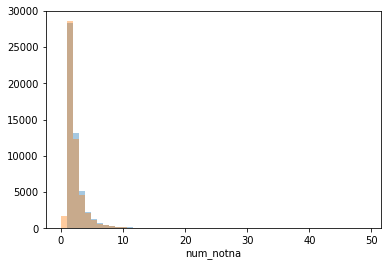

In [198]:
sns.distplot(station_rain_data.num, kde=False)
sns.distplot(station_rain_data.num_notna, kde=False)

Text(0.5, 1.0, 'percent not NA')

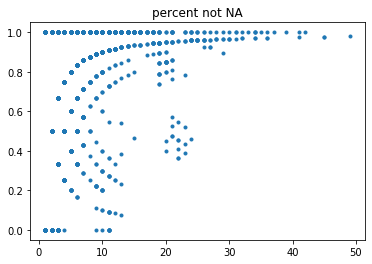

In [199]:
plt.plot(station_rain_data.num, station_rain_data.num_notna/station_rain_data.num, ".")
plt.title("percent not NA")

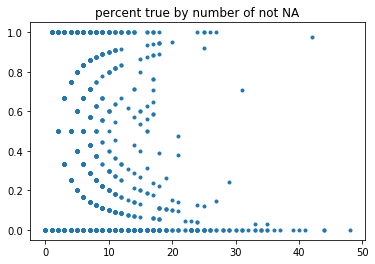

In [195]:
plt.title("percent true by number of not NA")
plt.plot(station_rain_data.num_notna, station_rain_data.p, ".")

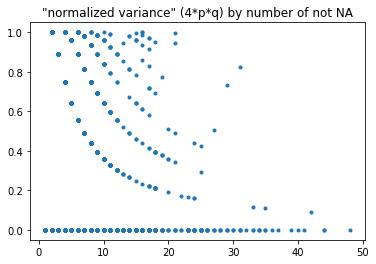

In [194]:
plt.title('"normalized variance" (4*p*q) by number of not NA')
plt.plot(station_rain_data.num_notna, 4 * station_rain_data.varp / station_rain_data.num_notna, ".")


In [179]:
sum((station_rain_data.p >= 0.25) & (station_rain_data.p <= 0.75)), len(station_rain_data.p)

(4181, 52725)